# 1D Example from Boninsegna (2018)

This notebook attempts to reproduce the 1D example from L. Boninsegna and C. Clementi, “Sparse learning of stochastic dynamical equations,” J. Chem. Phys., vol. 148, p. 241723, 2018.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataprep import *
from stochastic_sindy import *

import multiprocessing as mp # for simulating trajectories faster

## Time series

The form of the potential being used is
$$
U(x) = \frac{x^4}{2} - 4 x^3 + 9 x^2 -3 x,
$$
and hence the form of the force is
$$
F(X) = - U'(x) = -2 x^3 + 12 x^2 - 18 x + 3
$$

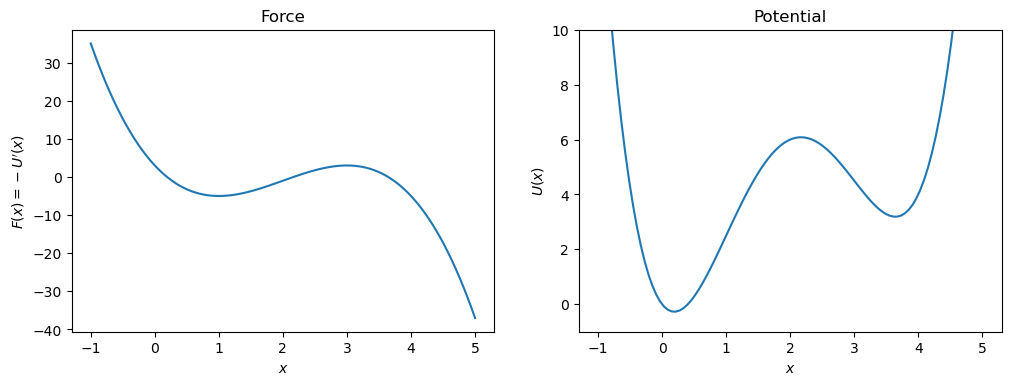

In [18]:
F = lambda x : 3 - 18*x  + 12*x**2 - 2*x**3
U = lambda x : -3*x + 9*x**2 - 4*x**3 + 0.5*x**4
x = np.linspace(-1,5,100)
fig, axs = plt.subplots(1,2, figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
axs[0].plot(x,F(x))
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x) = -U'(x)$")
axs[0].set_title("Force")
axs[1].plot(x,U(x))
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$U(x)$")
axs[1].set_ylim([-1,10])
axs[1].set_title("Potential")
plt.show()

The paper describes simulating 5 trajectories of $N = 10^7$ steps with time increment $\Delta t = 5 \cdot 10^{-3}$ and diffusion coefficient $D = 1$. The initial conditions are not specified, but the long time series ensures that they are not very important.

As a result, we have a tall 5-column matrix $x_\text{multiple}$ containing the time series of the 5 trajectories.

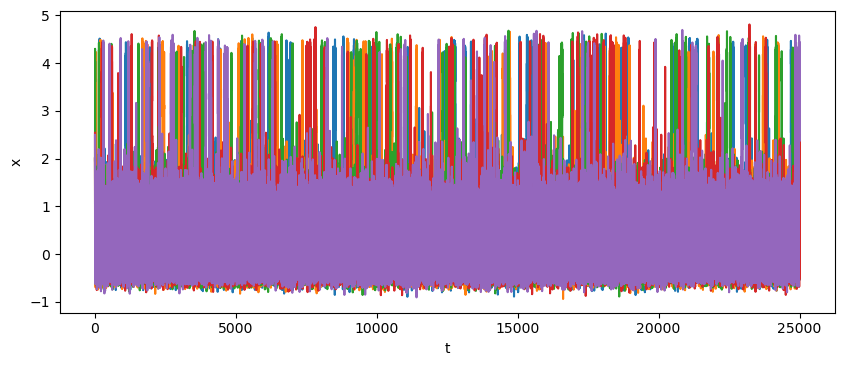

In [3]:
x_multiple = []
dt = 5e-3
n = int(5e6)
n_traj = 5
diffusion = 1
x0s = np.full(n_traj, 2) # all trajectories start at x=2
# x0s = np.linspace(0,4,n_traj)

def mp_ts(x0):
    np.random.seed()
    return time_series(F,x0,dt,n,diffusion)
    
pool = mp.Pool()
x_multiple = pool.map(mp_ts, x0s)
pool.close()
pool.join()

fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(n_traj):
    plt.plot(np.linspace(0,n*dt,n+1), x_multiple[i])
plt.ylabel("x")
plt.xlabel("t")
plt.show()

x_multiple = np.array(x_multiple).T

The instantaneous velocities are computed using the explicit Euler scheme and stored in the tall 5-column matrix $Y_\text{multiple}$ according to the respective points in the time series matrix $x_\text{multiple}$.

Each of these matrices are transformed into column vectors by stacking their columns, resulting in the two vectors $x_\text{single}$ and $Y_\text{single}$.

In [4]:
Y_multiple = ps.differentiation.FiniteDifference(order = 1)._differentiate(
    x_multiple, dt
)

# Stack the data into one column
Y_single = Y_multiple.reshape(-1, 1, order = 'F')
x_single = x_multiple.reshape(-1, 1, order = 'F')

## First set of basis functions

The paper explores its algorithm on two dictionaries with $K = 20$ (allegedly) basis functions:

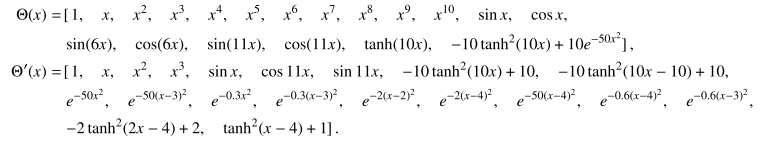

Note that $\Theta(x)$ actually has $K = 19$ functions.

Let us start with the first dictionary $\Theta(x)$.

In [20]:
basis1_fns = [
    lambda x : 1,
    lambda x : x,
    lambda x : x**2,
    lambda x : x**3,
    lambda x : x**4,
    lambda x : x**5,
    lambda x : x**6,
    lambda x : x**7,
    lambda x : x**8,
    lambda x : x**9,
    lambda x : x**10,
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x : np.sin(6*x),
    lambda x : np.cos(6*x),
    lambda x : np.sin(11*x),
    lambda x : np.cos(11*x),
    lambda x : np.tanh(10*x),
    lambda x : -10*np.tanh(10*x)**2 + 10*np.exp(-50*x**2)
]
basis1_names = [
    lambda x : '1',
    lambda x : x,
    lambda x : x+'^2',
    lambda x : x+'^3',
    lambda x : x+'^4',
    lambda x : x+'^5',
    lambda x : x+'^6',
    lambda x : x+'^7',
    lambda x : x+'^8',
    lambda x : x+'^9',
    lambda x : x+'^10',
    lambda x : 'sin('+x+')',
    lambda x : 'cos('+x+')',
    lambda x : 'sin(6*'+x+')',
    lambda x : 'cos(6*'+x+')',
    lambda x : 'sin(11*'+x+')',
    lambda x : 'cos(11*'+x+')',
    lambda x : 'tanh(10*'+x+')',
    lambda x : '-10 tanh(10*'+x+'$)^2$ + 10 exp(-50*'+x+'$**2$)'
]

basis1 = ps.CustomLibrary(
    library_functions=basis1_fns, function_names=basis1_names
)

To reduce the size of the problem, we condense the data from time series by binning. In particular, the paper chooses $Q = 90$ bins.The centres of the bins are thus stored in the column $x_\text{binned}$ and represent the new positions, whereas the velocities corresponding to each bin are averaged to obtain a similar column $Y_\text{binned}$. An array of weights are computed as the fractions of points from the time series that each bin has captured.

The basis functions can thus be evaluated at the binned positions $x_\text{binned}$ to obtain the matrix $X_\text{binned}$. A matrix of the weights $W$ is constructed as the diagonal matrix of the weight array.

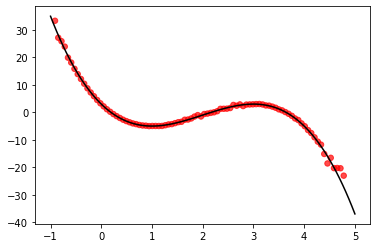

In [21]:
x_binned, Y_binned, weights = bin_data(x_single, Y_single, 90,
                                       width_type = 'equal')
basis1.fit(x_binned)
X_binned = basis1.transform(x_binned)
W = np.diag(weights)

plt.scatter(x_binned.squeeze(), Y_binned.squeeze(), s = 30*(weights > 0), 
            marker = 'o', facecolor = 'r', alpha = .7)
plt.plot(x,F(x), 'k')

plt.show()

The paper then describes running their algorithm for $n_\text{runs} = 50$ times under different combinations of cross validation with 5 folds. The squared cross validation scores are averaged to get the final $\delta$'s.

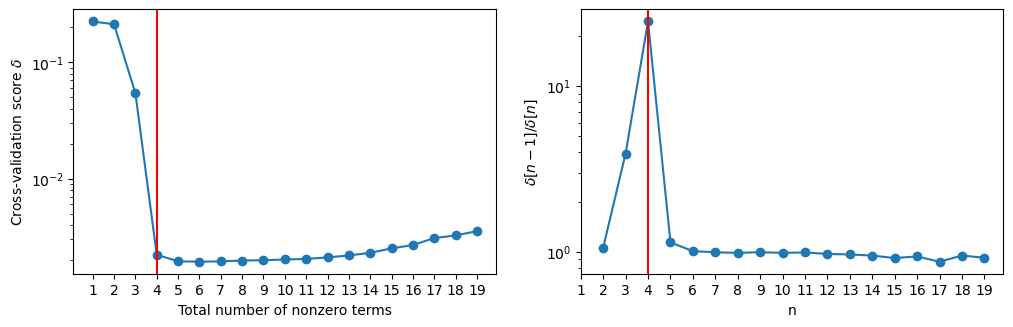

In [22]:
n_runs = 50
n_fns = X_binned.shape[1]

errors2 = np.zeros(n_fns)
for run in range(n_runs):
    errors2 += np.array(CV_score(np.matmul(W,X_binned), np.matmul(W,Y_binned), K=5))**2
errors = np.sqrt(errors2/n_runs)
    
error_ratios = errors[:-1]/errors[1:]
opt_n = np.argmax(error_ratios[:-1]/error_ratios[1:])+2


fig, axs = plt.subplots(1,2,figsize=(12,3.5), dpi= 100, facecolor='w', edgecolor='k')

axs[0].set_xticks(np.arange(1,n_fns+1,1))
axs[0].semilogy(np.arange(1, n_fns * Y_binned.shape[1] + 1, 1), errors, '-o')
axs[0].set_xlabel("Total number of nonzero terms")
axs[0].set_ylabel("Cross-validation score $\delta$")
axs[0].axvline(x=opt_n, color = 'red')

axs[1].semilogy(np.arange(2, n_fns * Y_binned.shape[1] + 1, 1), error_ratios, '-o')
axs[1].set_xticks(np.arange(1,n_fns+1,1))
axs[1].set_xlabel("n")
axs[1].set_ylabel("$\delta[n-1]/\delta[n]$")
axs[1].axvline(x=opt_n, color = 'red')

plt.show()

Compare to the paper's result:
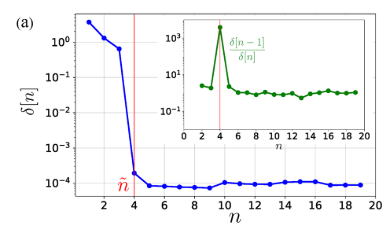

We thus use the found optimal value of number of terms $n$ to find the optimal set of functions:

The optimal set of basis functions is  ['1' 'x' 'x^2' 'x^3']


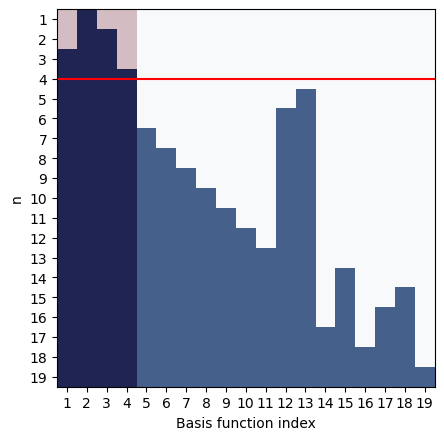

In [23]:
m = survival_matrix(np.matmul(W,X_binned), np.matmul(W,Y_binned))

extent = [.5,n_fns+.5,n_fns+.5,.5]

fig = plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
im1 = plt.imshow(m, cmap = 'Blues', extent = extent)

opt_fns_mask = np.array(m[opt_n-1,:], dtype = bool)
opt_fns = np.array(basis1.get_feature_names("x"))[opt_fns_mask]
print("The optimal set of basis functions is ", opt_fns)

opt_fns_m = [opt_fns_mask for i in range(n_fns)]
im2 = plt.imshow(opt_fns_m, cmap = 'Reds', alpha = 0.25, extent = extent)

plt.axhline(y=opt_n, color = 'red')

plt.xticks(np.arange(1,n_fns+1,1))
plt.yticks(np.arange(1,n_fns+1,1))
plt.xlabel("Basis function index")
plt.ylabel("n")

plt.show()

where the paper's sparsity progress matrix is presented as
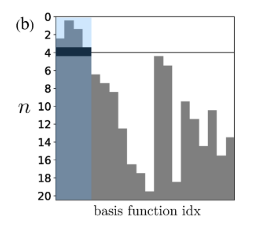

Finally, we compute the coefficients for these functions and thus obtain the predicted form of the force function:

Prediction: F(x) =  [  2.98056759 -17.85857474  11.8675056   -1.97392225] * ['1' 'x' 'x^2' 'x^3']


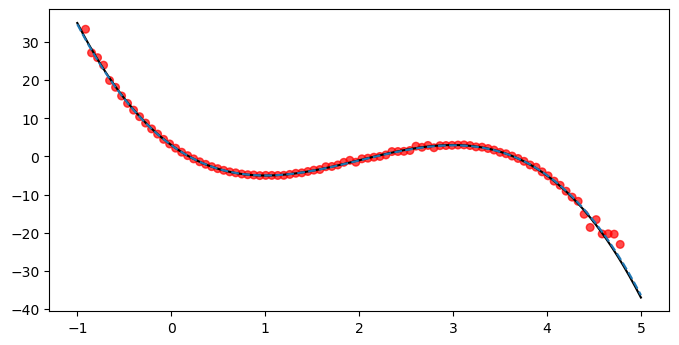

In [24]:
c, _ = SSR(np.matmul(W,X_binned), np.matmul(W,Y_binned), opt_fns_mask.reshape(-1,1))

c_opt = c.squeeze()[opt_fns_mask]
print('Prediction: F(x) = ', str(c_opt)+' *',np.array(basis1.get_feature_names("x"))[opt_fns_mask])

plt.figure(figsize=(8,4), dpi= 100)

plt.plot(x,F(x), 'k')

F_pred = np.zeros_like(x)
for i in range(opt_n):
    F_pred += c_opt[i]*np.array(basis1_fns)[opt_fns_mask][i](x)
plt.plot(x,F_pred, '--')

plt.scatter(x_binned.squeeze(), Y_binned.squeeze(), s = 30*(weights > 0), 
            marker = 'o', facecolor = 'r', alpha = .7)

plt.show()

## Second set of basis functions

We now repreat this process for the other dictionary of basis functions $\Theta'(x)$.

In [25]:
basis2_fns = [
    lambda x : 1,
    lambda x : x,
    lambda x : x**2,
    lambda x : x**3,
    lambda x : np.sin(x),
    lambda x : np.cos(11*x),
    lambda x : np.sin(11*x),
    lambda x : 10*(1-np.tanh(10*x)**2),
    lambda x : 10*(1-np.tanh(10*x-10)**2),
    lambda x : np.exp(-50*x**2),
    lambda x : np.exp(-50*(x-3)**2),
    lambda x : np.exp(-0.3*x**2),
    lambda x : np.exp(-0.3*(x-3)**2),
    lambda x : np.exp(-2*(x-2)**2),
    lambda x : np.exp(-2*(x-4)**2),
    lambda x : np.exp(-50*(x-4)**2),
    lambda x : np.exp(-0.6*(x-4)**2),
    lambda x : np.exp(-0.6*(x-3)**2),
    lambda x : 2*(1-np.tanh(2*x-4)**2),
    lambda x : np.tanh(x-4)**2+1,
]
basis2_names = [
    lambda x : '1',
    lambda x : x,
    lambda x : x+'^2',
    lambda x : x+'^3',
    lambda x : 'sin('+x+')',
    lambda x : 'cos(11*'+x+')',
    lambda x : 'sin(11*'+x+')',
    lambda x : '10(1-tanh(10*'+x+')^2)',
    lambda x : '10(1-tanh(10*'+x+'-10)^2)',
    lambda x : 'exp(-50*'+x+'^2)',
    lambda x : 'exp(-50('+x+'-3)^2)',
    lambda x : 'exp(-0.3*'+x+'^2)',
    lambda x : 'exp(-0.3('+x+'-3)^2)',
    lambda x : 'exp(-2('+x+'-2)^2)',
    lambda x : 'exp(-2('+x+'-4)^2)',
    lambda x : 'exp(-50('+x+'-4)^2)',
    lambda x : 'exp(-0.6('+x+'-4)^2)',
    lambda x : 'exp(-0.6('+x+'-3)^2)',
    lambda x : '2*(1-tanh(2*'+x+'-4)^2)',
    lambda x : 'tanh('+x+'-4)^2+1'
]

basis2 = ps.CustomLibrary(
    library_functions=basis2_fns, function_names=basis2_names
)

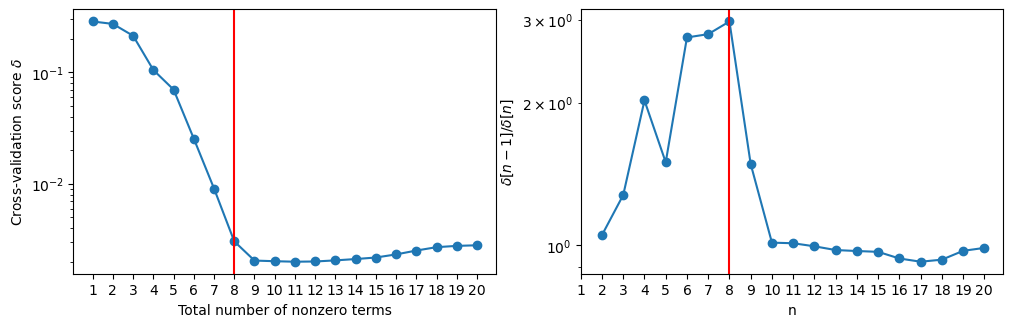

In [30]:
basis2.fit(x_binned)
X_binned = basis2.transform(x_binned)
W = np.diag(weights)

n_runs = 50
n_fns = X_binned.shape[1]

errors2 = np.zeros(n_fns)
for run in range(n_runs):
    errors2 += np.array(CV_score(np.matmul(W,X_binned), np.matmul(W,Y_binned), K=5))**2
errors = np.sqrt(errors2/n_runs)
    
error_ratios = errors[:-1]/errors[1:]
opt_n = np.argmax(error_ratios[:-1]/error_ratios[1:])+2


fig, axs = plt.subplots(1,2,figsize=(12,3.5), dpi= 100, facecolor='w', edgecolor='k')

axs[0].set_xticks(np.arange(1,n_fns+1,1))
axs[0].semilogy(np.arange(1, n_fns * Y_binned.shape[1] + 1, 1), errors, '-o')
axs[0].set_xlabel("Total number of nonzero terms")
axs[0].set_ylabel("Cross-validation score $\delta$")
axs[0].axvline(x=opt_n, color = 'red')

axs[1].semilogy(np.arange(2, n_fns * Y_binned.shape[1] + 1, 1), error_ratios, '-o')
axs[1].set_xticks(np.arange(1,n_fns+1,1))
axs[1].set_xlabel("n")
axs[1].set_ylabel("$\delta[n-1]/\delta[n]$")
axs[1].axvline(x=opt_n, color = 'red')

plt.show()

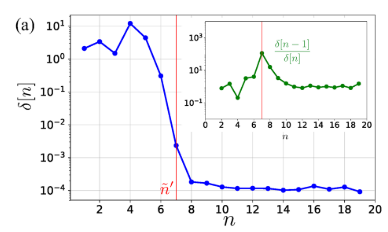

The optimal set of basis functions is  ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3*x^2)' 'exp(-0.3(x-3)^2)'
 'exp(-0.6(x-3)^2)' 'tanh(x-4)^2+1']


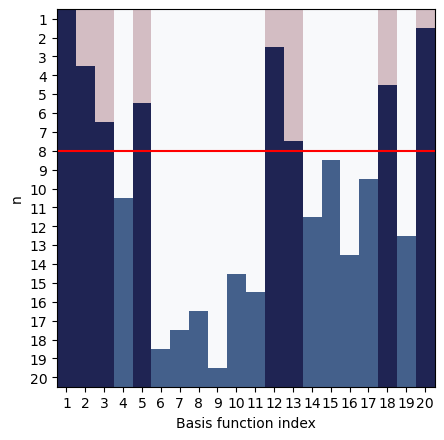

In [31]:
m = survival_matrix(np.matmul(W,X_binned), np.matmul(W,Y_binned))

extent = [.5,n_fns+.5,n_fns+.5,.5]

fig = plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
im1 = plt.imshow(m, cmap = 'Blues', extent = extent)

opt_fns_mask = np.array(m[opt_n-1,:], dtype = bool)
opt_fns = np.array(basis2.get_feature_names("x"))[opt_fns_mask]
print("The optimal set of basis functions is ", opt_fns)

opt_fns_m = [opt_fns_mask for i in range(n_fns)]
im2 = plt.imshow(opt_fns_m, cmap = 'Reds', alpha = 0.25, extent = extent)

plt.axhline(y=opt_n, color = 'red')

plt.xticks(np.arange(1,n_fns+1,1))
plt.yticks(np.arange(1,n_fns+1,1))
plt.xlabel("Basis function index")
plt.ylabel("n")

plt.show()

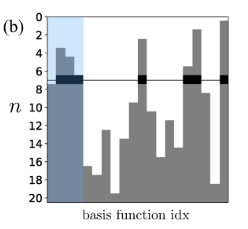

Prediction: F(x) =  [ 66.20191222 -34.4971051    5.37990982  15.72940479 -18.69274052
   3.75912296  22.75238941 -22.45768923] * ['1' 'x' 'x^2' 'sin(x)' 'exp(-0.3*x^2)' 'exp(-0.3(x-3)^2)'
 'exp(-0.6(x-3)^2)' 'tanh(x-4)^2+1']


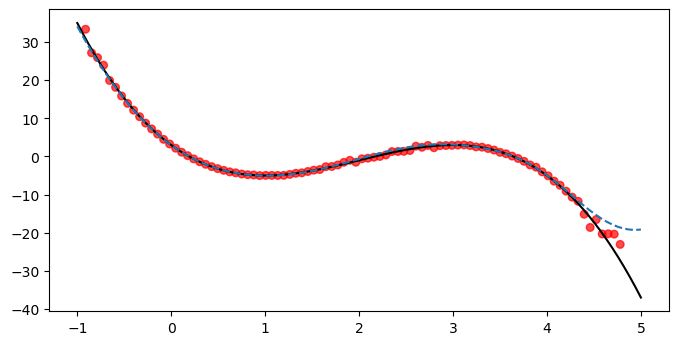

In [32]:
c, _ = SSR(np.matmul(W,X_binned), np.matmul(W,Y_binned), opt_fns_mask.reshape(-1,1))

c_opt = c.squeeze()[opt_fns_mask]
print('Prediction: F(x) = ', str(c_opt)+' *',np.array(basis2.get_feature_names("x"))[opt_fns_mask])

plt.figure(figsize=(8,4), dpi= 100)

plt.plot(x,F(x), 'k')

F_pred = np.zeros_like(x)
for i in range(opt_n):
    F_pred += c_opt[i]*np.array(basis2_fns)[opt_fns_mask][i](x)
plt.plot(x,F_pred, '--')

plt.scatter(x_binned.squeeze(), Y_binned.squeeze(), s = 30*(weights > 0), 
            marker = 'o', facecolor = 'r', alpha = .7)

plt.show()